# Urban Ecology Research Trend Analysis

Type: NLP + Time Series + Web Data | Domain: Scientific + environmental | Format: Notebook
- Use PubMed or Semantic Scholar API to extract papers on 'urban ecology'.
- Track number of publications per year.
- Perform keyword frequency and topic modeling.
- Map institutions or authors by location 
    .Use author search and Research Organization Registry (ror.org) to map institutions to locations.

In [ ]:
# For future author search

AUTHOR_URL = 'https://api.semanticscholar.org/graph/v1/author/batch'
AUTHOR_FIELDS = 'affiliations'
AUTHORS_DB_PATH = 'papers.db'
authors_schema = """
    authorId TEXT PRIMARY KEY,
    name TEXT,
    affiliation TEXT
"""

In [147]:
import os
import time
import requests
import pandas as pd
import numpy as np
import sqlite3
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

BASE_URL = 'http://api.semanticscholar.org/graph/v1/paper/search/bulk'
FIELDS = 'title,year,authors,url'
PUBLICATION_TYPES = 'Review,JournalArticle,Study,Book,BookSection'
DELAY = 5  # delay between requests to avoid rate limiting
RETRY_DELAY = 5  # seconds before retrying on failure
YEAR_RANGE = '1920-2024'
PAPERS_DB_PATH = 'papers.db'
papers_schema = """
    paperId TEXT PRIMARY KEY,
    title TEXT,
    year INTEGER,
    authors TEXT,
    url TEXT,
    search_keyword TEXT,
    firstAuthorId TEXT
"""

query_list = [
    'urban ecology',
    'urban biodiversity',
    'urban ecosystem',
    'urban green spaces',
    'urban wildlife',
    'urban vegetation',
]

In [148]:
# Run this to clear the .txt progress trackers

for keyword in query_list:
    done_file = f'done_{keyword}.txt'
    token_file = f'token_{keyword}.txt'
    if os.path.exists(done_file):
        os.remove(done_file)
        print(f'✅ Progress trackers for "{keyword}" removed.')
    if os.path.exists(token_file):
        os.remove(token_file)
        print(f'✅ Progress trackers for "{keyword}" removed.')
  
if os.path.exists(PAPERS_DB_PATH):      
    os.remove(PAPERS_DB_PATH)
    print(f'✅ Output file "{PAPERS_DB_PATH}" removed.')

✅ Progress trackers for "urban ecology" removed.
✅ Progress trackers for "urban biodiversity" removed.
✅ Progress trackers for "urban ecosystem" removed.
✅ Progress trackers for "urban green spaces" removed.
✅ Progress trackers for "urban wildlife" removed.
✅ Progress trackers for "urban vegetation" removed.
✅ Output file "papers.db" removed.


In [137]:
# === Helper functions ===
# keeps track of keywords and tokens to allow to keep retrieving papers from 
# where you left off in case of a request/response error
def save_token(keyword, token):
    with open(f'token_{keyword}.txt', 'w') as f:
        f.write(token)

def load_token(keyword):
    filename = f'token_{keyword}.txt'
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return f.read().strip()
    return None

def mark_done(keyword):
    with open(f'done_{keyword}.txt', 'w') as f:
        f.write('completed')

def is_done(keyword):
    return os.path.exists(f'done_{keyword}.txt')

def delete_token(keyword):
    filename = f'token_{keyword}.txt'
    if os.path.exists(filename):
        os.remove(filename)


In [138]:
# === Database and Dataframe setup ===

def init_table(db_path, table_name, schema_sql):
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(f"CREATE TABLE IF NOT EXISTS {table_name} ({schema_sql})")
    conn.commit()
    conn.close()
    
def save_paper_to_db(paper, keyword):
    conn = sqlite3.connect(PAPERS_DB_PATH)
    c = conn.cursor()

    paper_id = paper.get("paperId")
    title = paper.get("title")
    year = paper.get("year")
    url = paper.get("url")
    authors_list = paper.get("authors", [])
    authors = ", ".join([a.get("name") for a in authors_list if a.get("name")])
    first_author_id = authors_list[0].get("authorId") if authors_list else None

    try:
        c.execute("SELECT search_keyword FROM papers WHERE paperId = ?", (paper_id,))
        existing = c.fetchone()
        
        if existing:
            existing_keywords = existing[0].split(", ") if existing[0] else []
            if keyword not in existing_keywords:
                existing_keywords.append(keyword)
                updated_keywords = ", ".join(existing_keywords)
                c.execute("UPDATE papers SET search_keyword = ? WHERE paperId = ?", 
                         (updated_keywords, paper_id))
        else:
            c.execute("""
                INSERT INTO papers 
                (paperId, title, year, authors, url, search_keyword, firstAuthorId)
                VALUES (?, ?, ?, ?, ?, ?, ?)
            """, (paper_id, title, year, authors, url, keyword, first_author_id))
        
        conn.commit()
    except sqlite3.Error as e:
        print(f"❌ DB error for paper {paper_id}: {e}")
    finally:
        conn.close()

In [149]:
# === Main loop over keywords ===

init_table(PAPERS_DB_PATH, "papers", papers_schema)

for keyword in query_list:
    print(f'\n🔍 Processing keyword: "{keyword}"')

    if is_done(keyword):
        print(f'✅ Keyword "{keyword}" already completed. Skipping.')
        continue

    token = load_token(keyword)
    if token:
        print(f'🔄 Resuming from saved token for "{keyword}": {token}')
    else:
        print(f'⏳ Starting fresh for keyword "{keyword}"')

    retrieved = 0

    while True:
        params = {
            'query': keyword,
            'fields': FIELDS,
            'publicationTypes': PUBLICATION_TYPES,
            'limit': 1000
        }
        if YEAR_RANGE:
            params['year'] = YEAR_RANGE
        if token:
            params['token'] = token

        # Retry logic
        for attempt in range(2):
            try:
                response = requests.get(BASE_URL, params=params, timeout=15)
                response.raise_for_status()
                data = response.json()
                break
            except requests.exceptions.RequestException as e:
                print(f'❌ Request error on attempt {attempt+1} for "{keyword}": {e}')
                if attempt == 0:
                    print(f'⏳ Retrying after {RETRY_DELAY} seconds...')
                    time.sleep(RETRY_DELAY)
                else:
                    print('⚠️ Skipping this batch due to repeated failure.')
                    data = None

        if data is None:
            print(f'⚠️ No data retrieved for keyword "{keyword}", breaking loop.')
            break

        papers = data.get('data', [])
        if not papers:
            print(f'⚠️ No papers returned, assuming end of results for "{keyword}"')
            break

        retrieved += len(papers)
        print(f'📄 Retrieved {retrieved} papers so far for "{keyword}"')

        for paper in papers:
            save_paper_to_db(paper, keyword)

        token = data.get('token')
        if token:
            token = data['token']
            save_token(keyword, token)
            time.sleep(DELAY)
        else:
            print(f'✅ Completed all pages for "{keyword}"')
            delete_token(keyword)
            mark_done(keyword)
            break

print('\n🎉 All keywords processed.')


🔍 Processing keyword: "urban ecology"
⏳ Starting fresh for keyword "urban ecology"
📄 Retrieved 1000 papers so far for "urban ecology"
📄 Retrieved 2000 papers so far for "urban ecology"
📄 Retrieved 3000 papers so far for "urban ecology"
📄 Retrieved 4000 papers so far for "urban ecology"
📄 Retrieved 5000 papers so far for "urban ecology"
📄 Retrieved 5973 papers so far for "urban ecology"
✅ Completed all pages for "urban ecology"

🔍 Processing keyword: "urban biodiversity"
⏳ Starting fresh for keyword "urban biodiversity"
📄 Retrieved 1000 papers so far for "urban biodiversity"
📄 Retrieved 2000 papers so far for "urban biodiversity"
📄 Retrieved 3000 papers so far for "urban biodiversity"
📄 Retrieved 4000 papers so far for "urban biodiversity"
📄 Retrieved 5000 papers so far for "urban biodiversity"
📄 Retrieved 5903 papers so far for "urban biodiversity"
✅ Completed all pages for "urban biodiversity"

🔍 Processing keyword: "urban ecosystem"
⏳ Starting fresh for keyword "urban ecosystem"
📄 R

In [150]:
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    df_raw = pd.read_sql_query("""
    SELECT year, search_keyword
    FROM papers
    WHERE year < 2025 AND search_keyword IS NOT NULL AND search_keyword != ''
    """, conn)

rows = []
for _, row in df_raw.iterrows():
    keywords = [k.strip() for k in row['search_keyword'].split(',')]
    for keyword in keywords:
        if keyword:
            rows.append({'year': row['year'], 'search_keyword': keyword})

df_expanded = pd.DataFrame(rows)
df_keywords = df_expanded.groupby(['year', 'search_keyword']).size().reset_index(name='paper_count')

df_totals = df_expanded.groupby('year').size().reset_index(name='paper_count')
df_totals['search_keyword'] = 'total'

df_keywords = df_keywords.sort_values('year')
df_keywords.head()

,year,search_keyword,paper_count
0,1937,urban vegetation,1
1,1938,urban ecology,1
2,1940,urban vegetation,1
3,1943,urban ecology,1
4,1943,urban green spaces,1


In [122]:
color_map = {
    'urban ecology': '#6B9BD2',
    'urban biodiversity': '#E6A366',
    'urban green spaces': '#7FB069',
    'urban wildlife': '#D67B7B',
    'urban vegetation': '#B19CD9',
    'urban ecosystem': '#E6A8D0',
    'total': "#FFD700"
}


In [153]:
fig = px.line(
    df_keywords,
    x='year',
    y='paper_count',
    color='search_keyword',
    color_discrete_map=color_map,
    title='Research Papers Published by Year',
    markers=True,
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Papers',
    legend_title='Keyword',
    font=dict(size=12),
    width=1000,
    height=600,
    template='plotly_dark',
    xaxis=dict(showgrid=True,
               dtick=5,
               tickangle=45),
    yaxis=dict(showgrid=True),
)

fig.show()


Totals graph:

In [162]:
fig = px.line(
    df_totals,
    x='year',
    y='paper_count',
    color='search_keyword',
    color_discrete_map=color_map,
    title='Research Papers Published by Year',
    markers=True,
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Papers',
    legend_title='Keyword',
    font=dict(size=12),
    width=1000,
    height=600,
    template='plotly_dark',
    xaxis=dict(showgrid=True,
               dtick=5,
               tickangle=45),
    yaxis=dict(showgrid=True),
)

fig.show()

In [156]:
df_keyword_pivot = df_keywords.pivot(index='year', columns='search_keyword', values='paper_count')
df_rate = df_keyword_pivot.pct_change(fill_method=None)
df_rate.fillna(0, inplace=True)
df_rate.reset_index(inplace=True)

In [157]:
df_melted = df_rate.melt(id_vars="year", var_name="search_keyword", value_name="growth_rate")
df_melted['acceleration'] = df_melted.groupby('search_keyword')['growth_rate'].diff()
df_melted['growth_rolling_avg'] = df_melted['growth_rate'].rolling(window=3, min_periods=1).mean()
df_melted.head()

fig = px.line(
    df_melted,
    x='year',
    y='growth_rolling_avg',
    color='search_keyword',
    color_discrete_map=color_map,
    title='Publication Growth Rate by Year',
    markers=True,
    facet_col='search_keyword',
    facet_col_wrap=2,
)

for annotation in fig.layout.annotations:
    annotation.text = ""

fig.update_yaxes(title_text="Growth Rate (%)", matches=None)
fig.update_xaxes(title_text="Year", matches=None)

fig.update_layout(
    legend_title='Keyword',
    font=dict(size=12),
    width=1200,
    height=700,
    template='plotly_dark',
    xaxis=dict(showgrid=True,
               tickangle=45),
    yaxis=dict(showgrid=True),
)

fig.show()


# Regression Analysis on All Papers Published

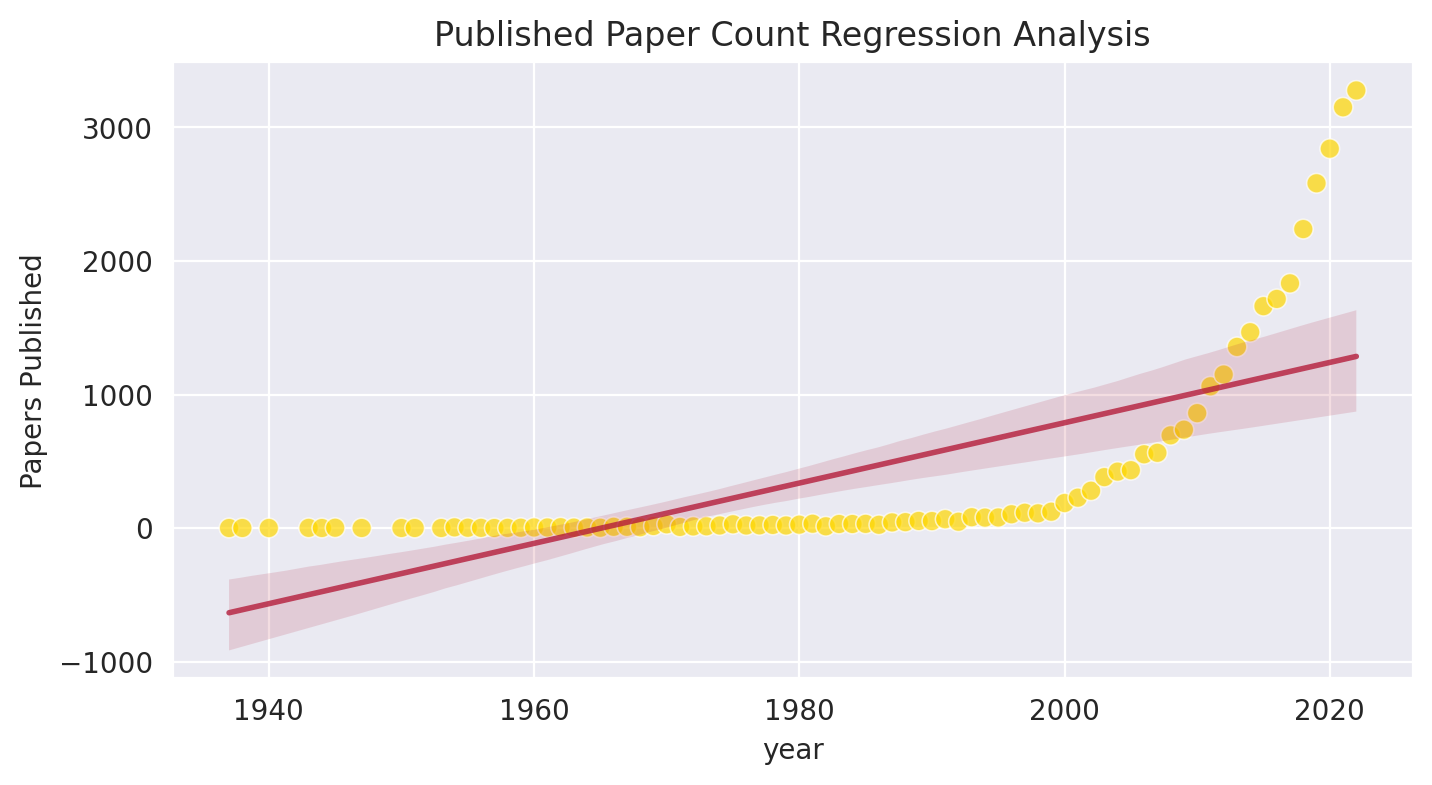

In [158]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('darkgrid'):
    with np.errstate(divide='ignore', over='ignore', invalid='ignore'):
        sns.scatterplot(
                data=df_totals.query('year < 2023'),
                x='year',
                y='paper_count',
                hue='search_keyword',
                palette=color_map,
                s=50,
                alpha=0.7,
                legend=False
            )
        ax = sns.regplot(
                data=df_totals.query('year < 2023'),
                x='year',
                y='paper_count',
                scatter=False,
                line_kws={
                    'linewidth': 2,
                    'alpha': 0.8,
                    'color': "#b41d3b"
                    },
            )

plt.title('Published Paper Count Regression Analysis')
plt.ylabel('Papers Published')
    
plt.show()


In [159]:
regression = LinearRegression()
X = pd.DataFrame(df_totals, columns=['year'])
y = pd.DataFrame(df_totals, columns=['paper_count'])
regression.fit(X, y)
print(f'R² Score: {round(regression.score(X, y),3)}')
print(f'Coefficient {round(regression.coef_[0][0],2)}')

R² Score: 0.322
Coefficient 34.68


Using the whole data, we see a relatively poor fit of the data on a linear regression model.
We can attempt it again, but adding a cutoff on the data to before 2023, as we see a huge spike on published paper numbers that could be a reflex on the 2019 COVID pandemic.

In [160]:
X = pd.DataFrame(df_totals.query('year < 2023'), columns=['year'])
y = pd.DataFrame(df_totals.query('year < 2023'), columns=['paper_count'])
regression.fit(X, y)
print(f'R² Score: {round(regression.score(X, y),3)}')
print(f'Coefficient {round(regression.coef_[0][0],2)}')

R² Score: 0.479
Coefficient 22.58


With the cutoff in place, the data shows an great fit, with an R² score above 0.9. This can indeed mean that th spike seen is likely an outlier, but we'll only find out for sure in a few years.  

Now let's analyze the data per keyword, and go a little deeper into the data.

# Per Keyword Analysis

Linear Regression Trend Analysis Results:
              keyword  slope_papers_per_year  r_squared       p_value  \
4     urban ecosystem              12.225990   0.576663  1.814917e-11   
5  urban biodiversity               7.469087   0.627010  5.322785e-09   
2  urban green spaces               6.337584   0.469484  7.905581e-09   
0    urban vegetation               5.155071   0.522894  1.027580e-11   
1       urban ecology               3.325586   0.599457  1.505642e-15   
3      urban wildlife               2.470619   0.618172  4.275800e-13   

       trend_interpretation  total_papers  
4  Significantly increasing          8965  
5  Significantly increasing          3781  
2  Significantly increasing          5221  
0  Significantly increasing          6119  
1  Significantly increasing          4595  
3  Significantly increasing          2498  


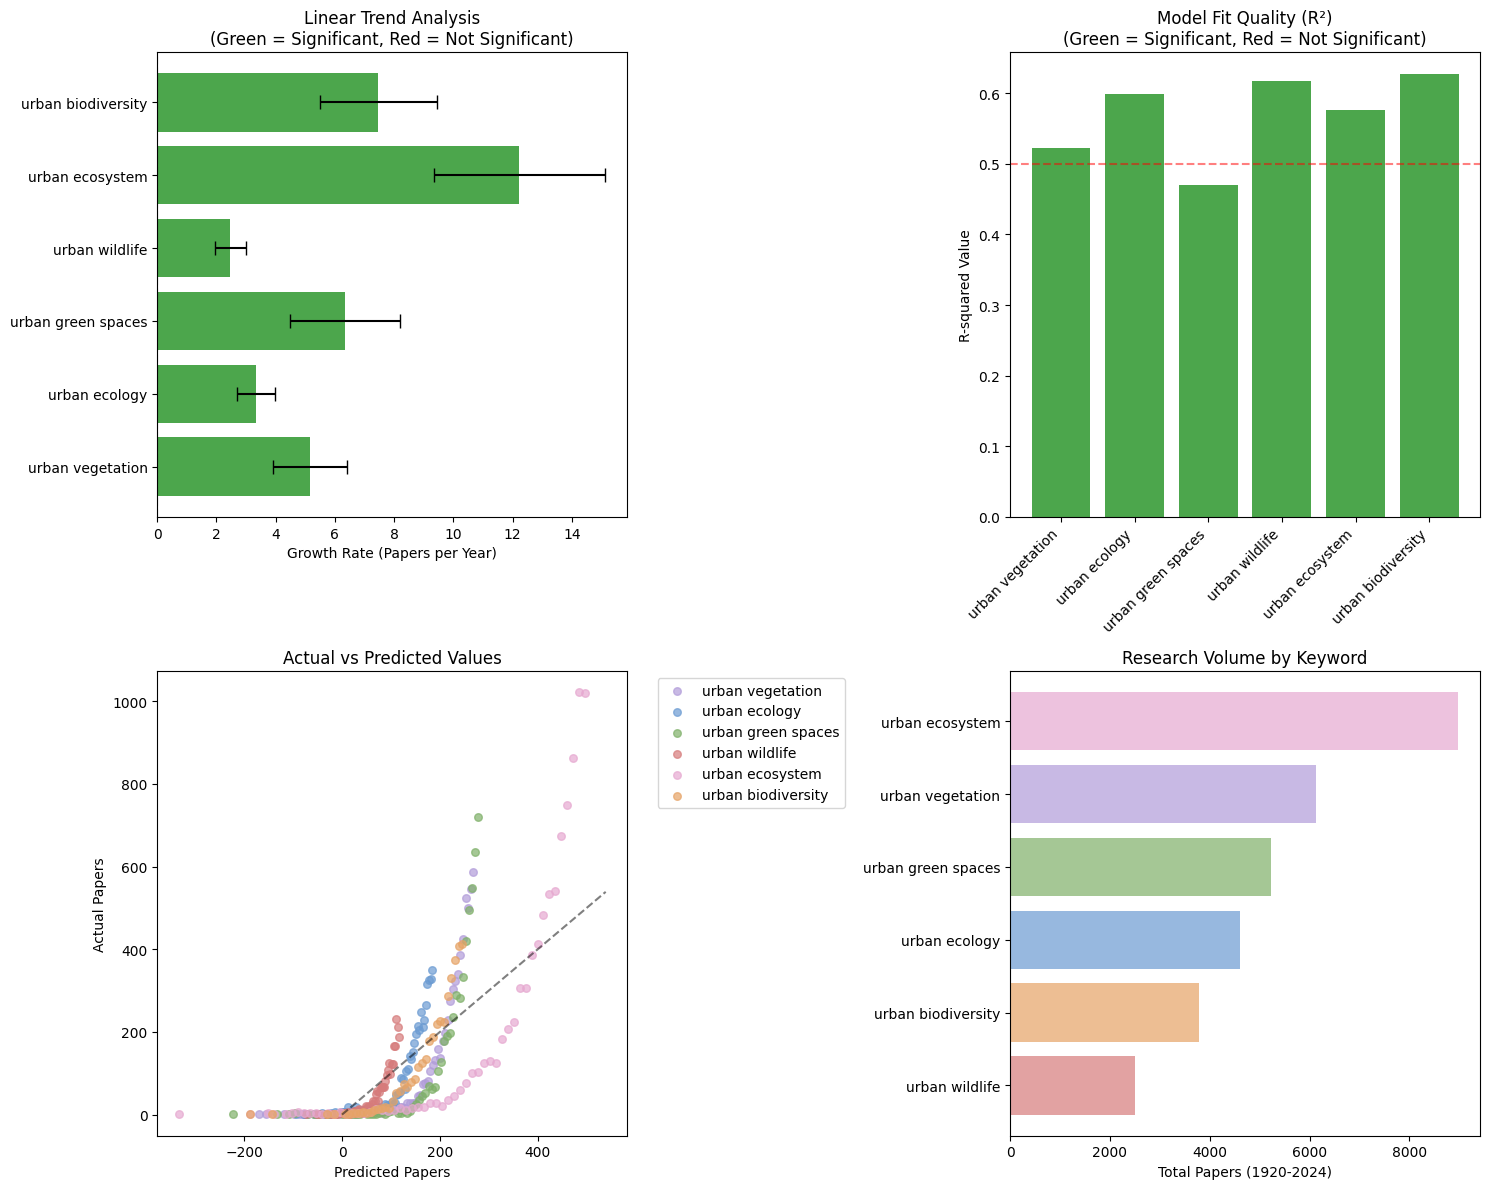


KEY INSIGHTS:
Fastest growing field: urban ecosystem (12.23 papers/year)
Most productive field: urban ecosystem (8965 total papers)
Fields with significant trends: 6/6
Best linear fit: urban biodiversity (R² = 0.627)


In [161]:
def linear_trend_analysis(df_keywords):
    """
    Perform linear regression analysis for each keyword
    Returns comprehensive trend statistics
    """
    results = []
    
    for keyword in df_keywords['search_keyword'].unique():
        keyword_data = df_keywords[df_keywords['search_keyword'] == keyword].sort_values('year')
        years = keyword_data['year'].values
        counts = keyword_data['paper_count'].values
        
        slope, intercept, r_value, p_value, std_err = linregress(years, counts)
        
        r_squared = r_value**2
        predicted_values = slope * years + intercept
        residuals = counts - predicted_values
        
        n = len(years)
        t_val = stats.t.ppf(0.975, n-2)
        slope_ci_lower = slope - t_val * std_err
        slope_ci_upper = slope + t_val * std_err
        
        if p_value < 0.05:
            if slope > 0:
                trend_interpretation = "Significantly increasing"
            else:
                trend_interpretation = "Significantly decreasing"
        else:
            trend_interpretation = "No significant trend"
        
        total_papers = counts.sum()
        avg_papers_per_year = counts.mean()
        
        results.append({
            'keyword': keyword,
            'slope_papers_per_year': slope,
            'intercept': intercept,
            'r_squared': r_squared,
            'p_value': p_value,
            'std_error': std_err,
            'slope_ci_lower': slope_ci_lower,
            'slope_ci_upper': slope_ci_upper,
            'trend_interpretation': trend_interpretation,
            'total_papers': total_papers,
            'avg_papers_per_year': avg_papers_per_year,
            'significant_trend': p_value < 0.05,
            'years_analyzed': n
        })
    
    return pd.DataFrame(results)

cutoff_keywords = df_keywords.query('year < 2023') # Cutoff at 2022 before the spike in papers

trend_results = linear_trend_analysis(cutoff_keywords)

print("Linear Regression Trend Analysis Results:")
print("=" * 60)
display_cols = ['keyword', 'slope_papers_per_year', 'r_squared', 'p_value', 
                'trend_interpretation', 'total_papers']
print(trend_results[display_cols].sort_values('slope_papers_per_year', ascending=False))

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Trend slopes with confidence intervals
ax1 = axes[0, 0]
colors = ['green' if sig else 'red' for sig in trend_results['significant_trend']]
keywords = trend_results['keyword']
slopes = trend_results['slope_papers_per_year']
ci_lower = trend_results['slope_ci_lower']
ci_upper = trend_results['slope_ci_upper']

y_pos = np.arange(len(keywords))
ax1.barh(y_pos, slopes, color=colors, alpha=0.7)
ax1.errorbar(slopes, y_pos, xerr=[slopes - ci_lower, ci_upper - slopes], 
            fmt='none', color='black', capsize=5)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(keywords)
ax1.set_xlabel('Growth Rate (Papers per Year)')
ax1.set_title('Linear Trend Analysis\n(Green = Significant, Red = Not Significant)')
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# 2. R-squared values
ax2 = axes[0, 1]
ax2.bar(range(len(trend_results)), trend_results['r_squared'], color=colors, alpha=0.7)
ax2.set_xticks(range(len(trend_results)))
ax2.set_xticklabels(keywords, rotation=45, ha='right')
ax2.set_ylabel('R-squared Value')
ax2.set_title('Model Fit Quality (R²)\n(Green = Significant, Red = Not Significant)')
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Moderate fit')

# 3. Actual vs predicted scatter plot for each keyword
ax3 = axes[1, 0]
for i, keyword in enumerate(keywords):
    keyword_data = cutoff_keywords[cutoff_keywords['search_keyword'] == keyword].sort_values('year')
    years = keyword_data['year'].values
    counts = keyword_data['paper_count'].values
    
    slope = trend_results[trend_results['keyword'] == keyword]['slope_papers_per_year'].iloc[0]
    intercept = trend_results[trend_results['keyword'] == keyword]['intercept'].iloc[0]
    predicted = slope * years + intercept
    
    ax3.scatter(predicted, counts, alpha=0.7, label=keyword, s=30,color=color_map.get(keyword, 'black'))

ax3.plot([0, max(ax3.get_xlim())], [0, max(ax3.get_xlim())], 'k--', alpha=0.5)
ax3.set_xlabel('Predicted Papers')
ax3.set_ylabel('Actual Papers')
ax3.set_title('Actual vs Predicted Values')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


# 4. Total research volume by keyword
ax4 = axes[1, 1]
total_papers = trend_results.set_index('keyword')['total_papers'].sort_values(ascending=True)
colors = [color_map.get(keyword, 'black') for keyword in total_papers.index]
ax4.barh(range(len(total_papers)), total_papers.values, color=colors, alpha=0.7)
ax4.set_yticks(range(len(total_papers)))
ax4.set_yticklabels(total_papers.index)
ax4.set_xlabel(f'Total Papers ({YEAR_RANGE})')
ax4.set_title('Research Volume by Keyword')

plt.tight_layout()
plt.show()

# Summary insights
print("\n" + "="*60)
print("KEY INSIGHTS:")
print("="*60)
fastest_growing = trend_results.loc[trend_results['slope_papers_per_year'].idxmax()]
print(f"Fastest growing field: {fastest_growing['keyword']} ({fastest_growing['slope_papers_per_year']:.2f} papers/year)")

most_productive = trend_results.loc[trend_results['total_papers'].idxmax()]
print(f"Most productive field: {most_productive['keyword']} ({most_productive['total_papers']:.0f} total papers)")

significant_trends = trend_results[trend_results['significant_trend']]
print(f"Fields with significant trends: {len(significant_trends)}/{len(trend_results)}")

best_fit = trend_results.loc[trend_results['r_squared'].idxmax()]
print(f"Best linear fit: {best_fit['keyword']} (R² = {best_fit['r_squared']:.3f})")